# Chapter 5. 데이터 전처리 및 차원 축소 (Data Preprocessing and Dimension Reduction)
퍼셉트론부터 시작해 결정 트리, 그리고 앙상블 기법까지 다양한 알고리즘이 개발되고 그 알고리즘들의 실용성(정확히는 비용과 시간 대비 예측 모델의 효율성)이 의심받는 상황 속에서, 데이터 직군의 사람들은 지금 있는 알고리즘만으로 최상의 성능을 내는 방법으로 관심을 돌리기 시작했습니다. 그 중에는 단순히 누락된 데이터를 어떤 수치로 채워넣을 것인지부터 시작해, 문자열 레이블 데이터를 어떻게 컴퓨터가 알아들을 수 있는 수치형 데이터로 전환할 것인지, 데이터 특성의 스케일을 균일하게 맞춰주는 것, 그리고 예측에 필요없는 특성들을 제거하고 꼭 필요한 특성만 솎아냄으로써 데이터의 차원을 축소하는 방법까지 방법론과 분야를 막론하고 다양한 기법이 제시되었습니다. 그리고 이들 중 상당수는 오늘날 판다스와 사이킷런 등의 모듈에 적용되어 데이터 분석의 기초라고 할 정도로 굳건한 초석으로 자리잡고 있습니다. 이번 시간에는 다양한 데이터 전처리 기법, 그리고 수많은 데이터 특성 중 데이터 분석에 반드시 필요한 특성만을 골라내는 기법인 차원 축소에 대해 다루겠습니다.

## 5.1 누락된 데이터 - 결측치 다루기
실제 애플리케이션에서는 여러 가지 이유로 훈련 샘플에 하나 이상의 값이 누락된 경우가 흔합니다. 데이터 수집 중에(특히 웹 크롤링 중에) 오류가 있었을 수도 있고, 어떤 측정 기법을 적용할 수 없어서 누락된 것일 수도 있죠. 또는 설문 조사에서 특정 필드가 그냥 비워져 있을 수도 있습니다(필수가 아니라 선택 답변 문항 등이 여기에 해당합니다). 일반적으로 누락된 값, 통칭 *결측치*는 데이터 테이블에 빈 공간이나 예약된 문자열로 채워집니다. 판다스에서는 우리가 일찍이 본 것처럼 `NaN`(Not-a-Number)로 채워지고, SQL 등의 관계형 데이터베이스는 `NULL`과 같은 값을 사용하는 것처럼요. 안타깝게도 대부분의 수치 라이브러리는 누락된 값 자체를 다룰 수 없거나 단순히 이를 무시하고 계산합니다(일반 파트 2단원 판다스 참조). 이 때문에 예상치 못한 결과를 만들어냅니다. 따라서 분석을 더 진행하기 전에 누락된 값을 반드시 처리해야 합니다.  

### 5.1.1 결측치 식별
누락된 값을 다루는 기법들을 설명ㅎ기 전에 이해를 돕기 위해 CSV로부터 간단한 예제 데이터셋을 만들어보겠습니다.

In [1]:
import pandas as pd
from io import StringIO # 문자열을 파일처럼 취급해서 다룰 수 있게 하는 파이썬 기본 함수입니다.
# (출처: https://docs.python.org/3/library/io.html#io.StringIO)

In [2]:
csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

In [3]:
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


문자열 데이터를 CSV 포맷 취급해서 판다스 데이터프레임으로 읽어들였습니다. 두 개의 누락된 값이 NaN으로 바뀌었죠? 아주 큰 데이터프레임이라면 이렇게 눈으로 NaN을 찾는 것이 아주 어려울 겁니다. 여기서 `isNull()` 메서드를 사용합니다. 이 메서드는 해당 셀(cell)이 수치 값을 담고 있으면 `False`를 결측치라서 NaN이라면 `True`를 표기하는 불리언 값의 데이터프레임을 반환합니다. 이 메서드를 `sum()`과 조합하면 누락된 값의 개수를 얻을 수 있습니다.  

> <span style='background-color:green'>Tips and Tricks</span> 
`isnull()`과 `isna()`의 차이<br/>아래 예제와 같이 `isnull()`을 자동완성하려고 하면, `isn` 정도까지만 타이핑했을 때 `isna()`라는 함수가 하나 더 뜹니다. 이름만 봐서는 결측치를 세는 것 같기는 한데... 얘를 써도 되는 걸까요?<br/>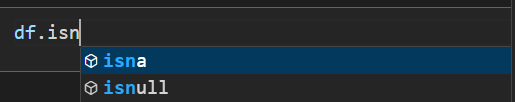<br/>결론부터 말하자면 **이 두 함수는 이름만 다르고 완전히 기능이 동일합니다.** `na`는 넘파이에서 결측치를 뜻하는 `Na`를 따온 것이기 때문에 이 메서드도 똑같이 결측치를 세는 기능을 수행합니다. 다만, 판다스를 사용하는 사람들이 대부분 SQL 등의 관계형 데이터베이스를 쓰다가 넘어오기 때문에 `NULL`에 익숙한 것을 감안해서 `isnull()`과 `isna()`를 둘 다 만들어놓은 것이 아닌가 조심스럽게 예상해봅니다.

In [4]:
df.isnull()

,A,B,C,D
0,False,False,False,False
1,False,False,True,False
2,False,False,False,True


In [5]:
df.isnull().sum() # sum()의 기본값이 axis=0으로 설정되어 있기 때문에, 각 열의 결측치 개수를 세어줍니다.

A    0
B    0
C    1
D    1
dtype: int64

> <span style='background-color:green'>Tips and Tricks</span> 사이킷런 사용과 관련한 판다스 팁<br/>
사이킷런은 넘파이 배열을 다룰 수 있도록 개발되었지만, 반대로 데이터 전처리는 판다스에 하는 것이 훨씬 편합니다. 사실 사이킷런의 대부분의 API에서 판다스 데이터프레임 사용도 지원하지만, 넘파이 배열 처리가 더욱 성숙하기 때문에 가능하면 넘파이 배열을 사용하는 것이 좋습니다. 사이킷런의 추정기에 주입하기 전에 `values` 속성을 사용해 넘파이 배열로 전환해줍시다.

In [6]:
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

### 5.1.2 결측치 핸들링 1 - 샘플이나 특성 제외
결측치를 다루는 가장 쉬운 방법은 데이터셋에서 해당 훈련 샘플(=행, row)이나 특성(=열, column)을 완전히 삭제하는 것입니다. 누락된 값이 있는 행은 `dropna()` 메서드를 사용해 삭제할 수 있습니다.
> <span style='background-color:green'>Tips and Tricks</span> 사이킷런의 내장 데이터셋 적재 함수 관련 테크닉<br/>
로지스틱 회귀까지 자주 사용했던 붓꽃 데이터셋을 불러오는 `load_iris()` 함수처럼 사이킷런 내부에 내장 데이터셋을 적재하는 함수에 `as_frame` 매개변수를 `True`로 지정하면 판다스 데이터프레임으로 반환해줍니다. 사이킷런 0.24 이상의 버전을 기준으로, openml.org에서 데이터를 내려받는 `fetch_openml` 함수의 `as_frame` 매개변수 기본값은 `False`에서 `'auto'`로 바뀝니다. `'auto'`일 경우 데이터가 희소(sparse, 행렬 등 배열의 원소가 대부분 0이고 일부 0이 아닌 원소를 포함하는 경우를 칭함)하지 않으면 자동으로 판다스 데이터프레임을 반환합니다.

In [7]:
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


`axis=0`으로 지정했더니 NaN이 하나라도 있는 *행*이 삭제되었습니다. 여기서 짐작했겠지만 `axis=1`로 바꾸면 NaN이 하나라도 있는 **열**을 삭제할 수 있습니다.

In [8]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


`dropna()` 메서드의 몇 가지 편리한 매개변수를 알아보겠습니다. `how` 매개변수 `'any'`(기본값) 또는 `'all'`을 입력으로 받습니다. 전자일 경우 특정 행 또는 열의 NaN이 하나라도 포함되어 있을 경우 열 또는 행을 삭제하고, 후자는 모든 행 또는 열이 Nan일 때만 삭제를 합니다. 여기서는 모든 값이 NaN인 행이 없기 때문에 모든 원소가 그대로 살아있는 전체 배열이 반환됩니다.

In [9]:
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


`thresh` 매개변수는 threshold의 약자로, NaN이 아닌 값(즉 수치 데이터)의 개수가 기준보다 낮은 행을 삭제합니다. 여기서는 결측치가 아닌 값이 네 개보다 적은 행을 삭제하겠습니다.

In [10]:
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


`subset` 매개변수는 특정 열에 NaN이 있는 행만 삭제합니다. 여기서는 'C'열에 NaN이 있는 행을 삭제하겠습니다.

In [11]:
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


결측치를 단순히 제거하기만 하는 것에는 아주 큰 맹점이 있습니다. 너무 많은 데이터를 제거하면 안정적인 분석이 불가능하다는 점입니다. 또는 너무 많은 컬럼을 제거하면 분류기가 클래스를 구분하는 데 필요한 중요한 정보를 잃을 수도 있습니다.

### 5.1.3 결측치 핸들링 2 - 대체(substitution), 보간(interpolation)
너무 많은 결측치를 제거해 샘플이나 특성이 모자랄 수도 있는 경우, 여러 가지 보간 기법을 사용해 데이터셋에 있는 다른 훈련 샘플로부터 누락된 값을 추정할 수 있습니다.  
가장 흔한 보간 기법 중 하나는 평균으로 대체하는 것입니다. 각 특성 컬럼 중 결측치가 아닌 수치 데이터들의 전체 평균으로 누락된 값을 바꿉니다. 사이킷런의 `SimpleImputer` 클래스를 사용하면 간편하게 처리할 수 있습니다.

In [12]:
from sklearn.impute import SimpleImputer
import numpy as np

In [13]:
imr = SimpleImputer(missing_values=np.nan, strategy='mean')

In [14]:
imr = imr.fit(df.values)

In [15]:
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

`strategy` 매개변수에 보간 방법을 지정합니다. 지금은 평균으로 보간을 진행했기 때문에 `'mean'`이 들어갔죠. `SimpleImputer` 클래스의 `strategy` 매개변수의 기본값이기도 합니다. 하지만 여기에 중간값 `'median'`, 최빈값 `'most_frequent'` 등을 이용할 수도 있습니다. 특히 최빈값 옵션은 범주형 특성을 대체할 때 유용합니다. 이외에 `'constant'` 옵션을 줄 경우, `fill_value`라는 매개변수에 채우려는 값을 지정해줘야 합니다.  
```Python
# strategy = 'constant' 예시
imr = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=7)
```


누락된 값을 채우는 더 쉬운 방법은 판다스의 `fillna()` 메서드에 매개변수로 누락된 값을 채울 방법을 전달하는 것입니다. 예를 들어 다음 명령을 사용하면 판다스 데이터프레임 객체에서 바로 평균값으로 누락된 값을 대체할 수 있습니다.

In [16]:
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


`fillna()` 메서드의 `method` 매개변수를 사용하여 누락된 값을 채울 수도 있습니다. `bfill` 또는 `backfill`은 누락된 값을 다음 행의 값으로 채웁니다. `ffill` 또는 `pad`는 누락된 값을 이전 행의 값으로 채웁니다.

In [17]:
df.fillna(method='bfill')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,12.0,8.0
2,10.0,11.0,12.0,NaN


In [18]:
df.fillna(method='ffill')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,3.0,8.0
2,10.0,11.0,12.0,8.0


`axis=1`로 지정하면 행이 아니라 열을 사용합니다. 예를 들어 다음처럼 지정하면 이전 열의 값으로 누락된 값을 채웁니다.

In [19]:
df.fillna(method='ffill', axis=1)

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,6.0,8.0
2,10.0,11.0,12.0,12.0



-----------------------------------------------------
`SimpleImputer` 클래스에는 `axis` 매개변수가 없습니다. 기본 동작 방식은 `Imputer` 클래스의 axis=0일 때와 같아 컬럼 방향으로만 처리할 수 있습니다. 따라서 행 방향으로 대체할 값을 계산하려면 다른 방법이 필요한데, 이 때 `FunctionTransformer`를 사용할 수 있습니다. 다음 예제는 입력 행렬의 행과 열을 바꾸어 대체할 값을 계산한 후 다시 변환된 행렬의 열과 행을 바꿉니다.

In [20]:
from sklearn.preprocessing import FunctionTransformer

In [21]:
ftr_imr = FunctionTransformer(lambda X: imr.fit_transform(X.T).T)

In [22]:
imputed_data = ftr_imr.fit_transform(df.values)
imputed_data

array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  6.33333333,  8.        ],
       [10.        , 11.        , 12.        , 11.        ]])

`SimpleImputer` 클래스의 `add_indicator` 매개변수를 `True`로 지정하면 `indicator_` 속성이 추가되고 `transform()` 메서드가 누락된 값의 위치를 포함된 배열을 반환합니다.

In [23]:
imr = SimpleImputer(add_indicator=True)

In [24]:
imputed_data = imr.fit_transform(df.values)

In [25]:
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ,  0. ,  0. ],
       [ 5. ,  6. ,  7.5,  8. ,  1. ,  0. ],
       [10. , 11. , 12. ,  6. ,  0. ,  1. ]])

추가된 `indicator_` 속성은 `MissingIndicator` 클래스의 객체입니다. `MissingIndicator` 객체의 `features_` 속성은 누락된 값이 있는 특성의 인덱스를 담고 있습니다.

In [26]:
imr.indicator_

MissingIndicator(error_on_new=False)

In [27]:
imr.indicator_.features_

array([2, 3], dtype=int64)

`MissingIndicator` 객체의 `fit_transform()` 메서드를 호출하면 `features_` 속성에 담긴 특성에서 누락된 값의 위치를 나타내는 배열을 반환합니다. 여기에서는 세 번째, 네 번째 특성의 누락된 값의 위치입니다. 이 배열의 값이 `SimpleImputer` 객체의 `transfrom()` 메서드가 반환한 배열의 마지막 두 열에 해당합니다.  
사이킷런 0.24 버전 이상에서는 `SimpleImputer` 클래스에 원본 특성으로 변환하는 `inverse_transform` 메서드가 추가되었습니다.

In [28]:
imr.indicator_.fit_transform(df.values)

array([[False, False],
       [ True, False],
       [False,  True]])

In [29]:
# 사이킷런 0.24 버전에서 추가되었습니다.
imr.inverse_transform(imputed_data)

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

`SimpleImputer`는 한 특성의 통곗값을 사용하여 누락된 값을 채웁니다. 이와 달리 `IterativeImputer` 클래스는 다른 특성을 사용하여 누락된 값을 예측합니다. 먼저 `initial_strategy` 매개변수에 지정된 방식으로 누락된 값을 초기화합니다. 그다음 누락된 값이 있는 한 특성을 타깃으로 삼고 다른 특성을 사용해 모델을 훈련하여 예측합니다. 이런 식으로 누락된 값이 있는 모든 특성을 순회합니다.  
`initial_strategy` 매개변수에 지정할 수 있는 값은 `SimpleImputer`와 동일하게 `'mean'`, `'median'`, `'most_frequent'`, `'constant'`가 가능합니다.  
예측할 특성을 선택하는 순서는 누락된 값이 가장 적은 특성부터 선택하는 `'ascending'`, 누락된 값이 가장 큰 특성부터 선택하는 `'descending'`, 왼쪽에서 오른쪽으로 선택하는 `'roman'`, 오른쪽에서 왼쪽으로 선택하는 `'arabic'`, 랜덤하게 고르는 `'random'`이 있습니다. 기본값은 `'ascending'`입니다.  
특성 예측은 종료 조건을 만족할 때까지 반복합니다. 각 반복 단계에서 이전 단계와 절댓값 차이 중 가장 큰 값이 누락된 값을 제외하고 가장 큰 절댓값에 `tol` 매개변수를 곱한 것보다 작을 경우 종료합니다. `tol` 매개변수 기본값은 1e-3입니다. 또는 `max_iter` 매개변수에서 지정한 횟수에 도달할 때 종료합니다. `max_iter`의 기본값은 10입니다.  
예측에 사용하는 모델은 `estimator` 매개변수에서 지정할 수 있으며 기본적으로 `BayesianRidge` 클래스를 사용합니다. 예측에 사용할 특성 개수는 `n_nearest_features`에서 지정할 수 있으며 상관 계수가 높은 특성을 우선하여 랜덤하게 선택합니다. 기본값은 `None`으로 모든 특성을 사용합니다.  

------------------------------------------

### 5.1.4 사이킷런 추정기 API 구조
`SimpleImputer` 클래스는 데이터 변환에 사용되는 사이킷런의 **변환기**(transformer) 클래스입니다. 이런 추정기의 주요 메서드 두 개는 `fit()`과 `transform()`입니다. `fit()` 메서드를 사용하여 훈련 데이터에서 모델 파라미터를 학습합니다. 이 파라미터를 바탕으로 `transform()`가 데이터를 변환합니다. **변환하려는 데이터 배열은 모델 학습에 사용한 데이터와 특성의 개수가 동일해야만 합니다.**  
아래 그림은 훈련 데이터셋에서 학습한 변환기가 훈련 데이터셋과 테스트 데이터셋을 변환하는 과정을 보여줍니다.
![그림 5-1](images/Fig5_1.png)  
반면 2 ~ 3단원에서 사용한 분류기는 변환기 클래스와 개념상 매우 유사한 API를 가진 사이킷런의 **추정기**(estimator)입니다. 추정기에는 `predict()` 메서드가 있지만 `transform()` 메서드도 가질 수 있습니다. 이 장 뒷부분에서 이런 예시를 소개하도록 하죠. 분류를 위한 추정기를 훈련할 때 `fit()` 메서드를 사용해서 모델의 파라미터를 학습했습니다. 지도 학습 작업에서는 모델을 훈련할 때 추가적으로 클래스 레이블을 제공합니다. 그다음 `predict()` 메서드를 사용해 레이블이 없는 새로운 데이터 샘플에 대한 예측을 만듭니다.  
![그림 5-2](images/Fig5_2.png)  

## 5.2 범주형 데이터
지금까지는 주로 수치형 데이터를 사용했습니다. 그러나 실제 데이터셋은 하나 이상의 범주형(categorical) 특성이 포함된 경우가 많습니다. 이 절에서 간단하지만 효과적인 예를 사용하여 이런 데이터를 수치 계산용 라이브러리에서 어떻게 다루는지 알아보겠습니다.  
범주형 데이터에 관해 이야기할 때 *순서가 있는 것*과 *순서가 없는 것*을 구분해야 합니다. 순서가 있는 특성은 정렬하거나 차례대로 놓을 수 있는 특성으로 생각할 수 있습니다. 예를 들어 티셔츠 사이즈는 XL → L → M으로 순서를 정할 수 있으므로 순서가 있는 특성입니다. 반대로 순서가 없는 특성은 차례를 부여할 수 없습니다. 티셔츠에 색은 순서가 없는 특성으로 볼 수 있을 겁니다. 일반적으로 빨강이 파랑보다 더 크다거나 말할 수 없죠.

-------------------------------------------
범주형 데이터를 다루는 여러 기법을 살펴보기 전에 예제를 위한 새로운 데이터프레임을 만들어보겠습니다.

In [30]:
df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

In [31]:
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


여기서 볼 수 있듯이 새롭게 만든 데이터프레임에는 순서가 없는 특성인 color와 순서가 있는 특성인 size, 수치형 특성인 price가 있습니다. 클래스 레이블은 마지막 열에 저장되어 있습니다. 책에서 다루는 분류 학습 알고리즘은 순서가 있는 클래스 레이블을 사용하지 않습니다.

### 5.2.1 순서가 있는 특성 매핑
학습 알고리즘이 순서 특성을 올바르게 인식하려면 범주형의 문자열 값을 *정수*로 바꿔야 합니다. 안타깝지만 `size` 특성의 순서를 올바르게 자동으로 바꾸어주는 함수는 없기 때문에 매핑 함수를 직접 만들어야 합니다. 여기서는 특성 간의 산술적인 차이를 이미 알고 있다고 가정합니다. 예를 들어 다음과 같습니다.  
$$XL = L + 1 = M + 2$$

In [32]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

In [33]:
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


만약 나중에 정수 값을 다시 원래 문자열 표현으로 바꾸고 싶다면, 간단히 거꾸로 매핑하는 딕셔너리를 정의하면 됩니다. 앞서 `size_mapping` 딕셔너리와 비슷하게 판다스의 `map()` 메서드를 사용해 변환된 특성 열에 적용할 수 있습니다. 딕셔너리 컴프리헨션을 이용하여 정의한 이 딕셔너리는 아래와 같습니다.

In [34]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

### 5.2.2 클래스 레이블 인코딩
많은 머신러닝 라이브러리는 클래스 레이블이 정수로 인코딩되어 있을 것이라고 기대합니다. 사이킷런의 분류 추정기 대부분은 자체적으로 클래스 레이블을 정수로 변호나해주지만 사소한 실수를 방지하기 위해 클래스 레이블을 정수 배열로 전달하는 것이 좋은 습관입니다. 클래스 레이블 인코딩도 앞서 순서 특성을 매핑한 것과 비슷한 방식을 사용합니다. 클래스 레이블은 순서가 없다는 것을 기억하세요. 특정 문자열 레이블에 할당한 정수는 아무런 의미가 없습니다. `enumerate`를 사용하여 클래스 레이블을 0부터 할당합니다.

In [35]:
class_mapping = {label:idx for idx, label in
                 enumerate(np.unique(df['classlabel']))}

In [36]:
class_mapping

{'class1': 0, 'class2': 1}

이어서 매핑 딕셔너리를 사용하여 클래스 레이블을 정수로 변환합니다.

In [37]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


클래스 레이블에서도 매핑 딕셔너리의 키-값 쌍을 뒤집어서 변환된 클래스 레이블을 다시 원본 문자열로 바꿀 수 있습니다.

In [38]:
inv_class_mapping = {v:k for k,v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


여기서 함정카드를 오픈하자면, 사이킷런에 구현된 `LabelEncoder` 클래스를 사용하면 편리합니다. 이 클래스에는 역변환까지도 구현되어 있습니다.

In [39]:
from sklearn.preprocessing import LabelEncoder

In [40]:
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

`fit_transform()` 메서드는 `fit()` 메서드와 `transform()` 메서드를 합쳐놓은 단축 메서드입니다. `inverse_transform()` 메서드가 역변환 메서드에 해당합니다. 정수 클래스 레이블을 원본 문자열 형태로 되돌릴 수 있습니다.

In [41]:
# 역변환 - 거꾸로 매핑
class_le.inverse_transform(y)

array(['class2', 'class1', 'class2'], dtype=object)

### 5.2.3 순서가 없는 특성에 원-핫 인코딩 적용
앞서 5.2.1 절에서 간단한 딕셔너리 매핑 방식을 이용해 순서를 가진 `size` 특성을 정수로 변환했습니다. 사이킷런의 분류용 추정기는 클래스 레이블을 순서가 없는 범주형 데이터로 다루기 때문에 `LabelEncoder`를 사용하여 간편하게 문자열 레이블을 정수로 인코딩했습니다. 순서가 없는 `color` 열에도 비슷한 방식을 사용할 수 있습니다.

In [42]:
X = df[['color', 'size', 'price']].values

In [43]:
color_le = LabelEncoder()

In [44]:
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

앞 코드를 실행하면 넘파이 배열 `X`의 첫 번째 열은 이제 다음과 같은 새로운 `color` 값을 가집니다.
* `blue` = 0
* `green` = 1
* `red` = 2

> <span style='background-color:green'>Tips and Tricks</span> `LabelEncoder` 사용 시 주의사항<br/>
`LabelEncoder`는 타겟 레이블을 인코딩하기 위한 클래스이므로 입력 데이터로 1차원 배열을 기대합니다. 앞 코드에서 `color` 열만 추출해서 `LabelEncoder` 객체에 주입한 것은 바로 이 때문입니다. 데이터셋에 변경해야 할 열이 많다면 동일한 작업을 반복해야 하므로 번거롭습니다. 범주형 데이터를 정수로 인코딩하는 `OrdinalEncoder`와 판다스 데이터프레임의 열마다 다른 변환을 적용하도록 도와주는 `ColumnTransformer`를 이용하면 여러 개의 열을 한 번에 정수로 변환할 수 있습니다. 코드는 아래와 같습니다.

In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

In [46]:
ord_enc = OrdinalEncoder(dtype=np.int32)
col_trans = ColumnTransformer([('ord_enc', ord_enc, ['color'])])

In [47]:
X_trans = col_trans.fit_transform(df)
X_trans

array([[1],
       [2],
       [0]])

`ColumnTransformer`는 첫 번째 매개변수로 트랜스포머(transformer)의 리스트를 받습니다. 트랜스포머는 이름, 변환기, 변환할 열의 리스트로 이루어진 튜플을 뜻합니다. 여기서는 이름은 `ord_enc`, 변환기는 `OrdinalEncoder` 객체, 변환할 열은 `color` 하나를 지정했습니다. 결과에서 알 수 있듯이, `color` 열이 정수 값으로 변환되었습니다. 이 튜플이 여러 개 적용된 케이스는 바로 아래 원-핫 인코딩 파트에서 소개하겠습니다.  
`ColumnTransformer`에 사용한 변환기는 `named_transformers_` 속성에서 앞서 지정한 `ord_enc` 이름으로 참조할 수 있습니다. 정수로 인코딩된 값을 다시 문자열로 역변환하려면 다음과 같이 `OrdinalEncoder`의 `inverse_transform()` 메서드를 호출합니다.

In [48]:
col_trans.named_transformers_['ord_enc'].inverse_transform(X_trans)

array([['green'],
       ['red'],
       ['blue']], dtype=object)

---------------------------------------
여기서 멈추고 이 배열을 분류기에 주입하면 범주형 데이터를 다룰 때 흔히 저지르는 실수 중 하나가 나옵니다. 문제가 무엇인지 눈치챘나요? 컬러 값에 어떤 순서가 없지만 학습 알고리즘이 `green`은 `blue`보다 크고, `red`는 `green`보다 크다고 가정할 것입니다. 이 가정이 옳지 않지만 알고리즘이 의미 있는 결과를 만들 수는 있을 겁니다. 그러나 그 결과는 절대 최선이 아닐 것입니다.  
이 문제를 해결하기 위해 통상적으로 **원-핫 인코딩**(one-hot encoding) 기법을 사용합니다. 이 방식은 순서 없는 특성에 들어 있는 고유한 값마다 새로운 더미(dummy) 특성을 만드는 것입니다. 여기서는 `color` 특성을 세 개의 새로운 특성인 `blue`, `green`, `red`로 변환합니다. 이진 값을 사용하여 특정 샘플의 `color`를 나타냅니다. 예를 들어 `blue` 샘플은 `blue=1, green=0, red=0`으로 인코딩됩니다. 사이킷런의 `preprocessing` 모듈에 구현된 `OneHotEncoder`를 사용하여 이런 변환을 수행할 수 있습니다.

In [49]:
from sklearn.preprocessing import OneHotEncoder

In [50]:
X = df[['color', 'size', 'price']].values

In [51]:
color_ohe = OneHotEncoder()

In [52]:
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

배열의 다른 두 열을 수정하지 않기 위해 `OneHotEncoder`를 하나의 열(`X[:, 0].reshape(-1, 1)`)에만 적용했습니다. 여러 개의 특성이 있는 배열에서 특정 열만 변환하려면 `ColumnTransformer`를 사용합니다. 앞서 설명한 것처럼 `(name, transformer, column(s))` 튜플들로 구성된 리스트를 받습니다.

In [53]:
X = df[['color', 'size', 'price']].values

In [54]:
# 아무 변환도 하지 않는 컬럼은 `'passthrough'`라고 지정합니다!
c_transf = ColumnTransformer([ ('onehot', OneHotEncoder(), [0]),
                               ('nothing', 'passthrough', [1, 2])])

In [55]:
c_transf.fit_transform(X)

array([[0.0, 1.0, 0.0, 1, 10.1],
       [0.0, 0.0, 1.0, 2, 13.5],
       [1.0, 0.0, 0.0, 3, 15.3]], dtype=object)

원-핫 인코딩으로 더미 변수를 만드는 더 편리한 방법은 판다스의 `get_dummies()` 메서드를 사용하는 것입니다. 데이터프레임에 적용하면 `get_dummies()` 메서드는 문자열 컬럼만 변환하고 나머지 컬럼은 그대로 둡니다.

In [56]:
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


`get_dummies()` 메서드에 `columns` 매개변수를 사용하면 다음과 같이 변환하려는 특성을 구체적으로 지정할 수 있습니다. 아래 예제는 조금 뜬금없지만 문자열 데이터인 `color` 대신 정수형 레이블 데이터인 `size`를 변환해본 것입니다.

In [57]:
pd.get_dummies(df[['price', 'color', 'size']], columns=['size'])

,price,color,size_1,size_2,size_3
0,10.1,green,1,0,0
1,13.5,red,0,1,0
2,15.3,blue,0,0,1


원-핫 인코딩된 데이터셋을 사용할 때는 다중 공선성(multi-collinearity, 독립변수들 간에 강한 상관관계가 나타나는 문제) 문제에 유의해야 합니다. 특정 2차원 배열의 역행렬을 구하는 과정이 포함된 알고리즘에 사용할 경우 역행렬을 구할 수 없어 성능 상의 치명적인 이슈가 발생할 수 있습니다. 변수 간의 상관관계를 감소하려면 원-핫 인코딩된 배열에서 특성 열 하나를 삭제합니다. 이렇게 특성을 삭제해도 잃는 정보는 없습니다. 예를 들어 `color_blue` 열을 삭제해도 샘플이 `color_green=0`이고 `color_red=0`일 때 `blue`임을 알 수 있습니다.  
`get_dummies()`를 사용할 때 `drop_first` 매개변수를 `True`로 지정하여 첫 번째 열을 삭제할 수 있습니다.

In [58]:
pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


`OneHotEncoder`에서 중복된 열을 삭제하려면 다음과 같이 `drop='first'`와 `categories='auto'`로 지정해야 합니다.

In [59]:
color_ohe = OneHotEncoder(categories='auto', drop='first')

In [60]:
c_transf = ColumnTransformer([ ('onehot', color_ohe, [0]),
                               ('nothing', 'passthrough', [1, 2])])

In [61]:
c_transf.fit_transform(X)

array([[1.0, 0.0, 1, 10.1],
       [0.0, 1.0, 2, 13.5],
       [0.0, 0.0, 3, 15.3]], dtype=object)

#### 특강: 순서가 있는 특성 인코딩
순서가 있는 특성의 범주 사이에서 수치적 크기에 대해 확신이 없거나 두 범주 사이의 순서를 정의할 수 없다면 임곗값을 사용해 0과 1로 인코딩할 수 있습니다. 예를 들어 M, L, XL 값을 가진 특성 `size`를 2개의 새로운 특성 "x > M"와 "x > L"로 나눌 수 있습니다.

In [62]:
df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

In [63]:
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


판다스 데이터프레임의 `apply` 메서드를 사용하여 임계값 기준으로 특성을 인코딩하는 람다 함수를 적용할 수 있습니다.

In [64]:
df['x > M'] = df['size'].apply(lambda x: 1 if x in {'L', 'XL'} else 0)
df['x > L'] = df['size'].apply(lambda x: 1 if x == 'XL' else 0)
del df['size']
df

,color,price,classlabel,x > M,x > L
0,green,10.1,class2,0,0
1,red,13.5,class1,1,0
2,blue,15.3,class2,1,1


### 5.3 복습: 훈련 데이터셋과 테스트 데이터셋으로 분할
편향되지 않은 성능을 측정하기 위해서는 전체 데이터셋 중에서 무작위로 훈련 데이터셋과 테스트 데이터셋으로 분할합니다. 일단 판다스 라이브러리로 와인 데이터셋을 불러오겠습니다.

In [65]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
                      header=None)

In [66]:
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

In [67]:
print('Class labels', np.unique(df_wine['Class label']))

Class labels [1 2 3]


In [68]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


사이킷런의 `model_selection` 모듈에 있는 `train_test_split()` 함수를 사용하겠습니다. 자주 사용되지만 동시에 어떤 모듈에 있는지 참 헷갈리는 함수이기 때문에 자주 임포트하고 사용하면서 숙달하시면 되겠습니다.

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=0,
                                                    stratify=y)

`test_size=0.3`으로 지정했기 때문에 와인 샘플의 30%가 `X_test`와 `y_test`로 할당됩니다. 나머지 샘플 70%는 `X_train`와 `y_train`으로 배치됩니다. `stratify` 매개변수에 클래스 레이블 배열 `y`를 전달하면 훈련 데이터셋과 테스트 데이터셋에 있는 클래스 비율이 원본 데이터셋과 동일하게 유지됩니다.  
> <span style='background-color:green'>Tips and Tricks</span> 훈련 데이터셋과 테스트 데이터셋의 적절한 분할 비율<br/>
데이터셋을 훈련 데이터셋과 테스트 데이터셋으로 나누는 행위는 달리 말하면 학습 알고리즘에 도움이 될 수 있는 유익한 정보를 감추게 된다는 뜻이기도 합니다. 따라서 테스트 데이터셋에 너무 많은 정보를 떼어 놓아서는 안 됩니다. 반대로 테스트 데이터셋이 작으면 일반화 오차에 대한 추정은 더 부정확해진다는 뜻입니다. 훈련 데이터셋과 테스트 데이터셋으로 나눌 때 이 트레이드오프의 균형을 맞춰야 합니다. 실전에서 가장 많이 사용하는 비율은 데이터셋의 크기에 따라 **60:40, 70:30, 또는 80:20**입니다. 대용량 데이터셋일 경우 90:10 또는 99:1의 비율로 훈련 데이터셋과 테스트 데이텉셋을 나누는 것도 보통이고 적합합니다. 예를 들어 데이터셋에 10만 개 이상의 훈련 샘플이 있다면 일반화 성능을 잘 추정하기 위해 1만 개의 샘플만 테스트로 떼어 놓는다 해도 괜찮습니다. 자세한 내용은 이 참고 논문([Model Evaluation, Model Selection, and Algorithm
Selection in Machine Learning](https://arxiv.org/pdf/1811.12808.pdf))을 참조하세요.<br/>또한, 떼어놓았던 테스트 데이터셋을 버리지 말고 훈련과 평가 후에 전체 데이터셋으로 모델을 다시 훈련하여 모델의 예측 성능을 향상시키는 방법도 널리 사용됩니다. 이런 방식은 일반적으로 권장되지만, 데이터셋이 작고 테스트 데이터셋에 이상치(outlier)가 들어 있다면 일반화 성능이 오히려 떨어질 수 있습니다. 전체 데이터셋을 사용하여 모델을 다시 훈련한 후에는 이 모델의 성능을 평가할 독립된 데이터셋이 남아 있지도 않습니다.

## 5.4 특성 스케일 맞추기
특성 스케일 조정은 전처리 파이프라인에서 간과할 수 없는 아주 중요한 단계입니다. 3단원에서 다룬 결정 트리와 랜덤 포레스트를 제외하면 대부분의 머신러닝과 최적화 알고리즘은 특성의 스케일이 동일할 때 훨씬 성능이 좋습니다.  
특성 스케일 조정의 중요성은 간단한 예를 들어 설명할 수 있습니다. 두 개의 특성에서 첫 번째 특성이 1에서 10 사이 스케일을 가지고 있고 두 번째 특성은 1에서 10만 사이의 스케일을 가진다고 해보죠. 1단원의 아달린에서 제곱 오차 함수를 생각해 보면 알고리즘은 대부분 두 번째 특성에 대한 큰 오차에 맞추어 가중치를 최적화할 것입니다.  
그럼 스케일이 다른 특성을 맞추는 대표적인 방법 두 가지인 **정규화**(normalization)와 **표준화**(standardization)를 소개하겠습니다. 이 용어는 분야마다 조금씩 다르게 사용되기 때문에 문맥에 따라 의미를 이해하는 것이 좋습니다.
### 5.4.1 정규화
정규화는 특성의 스케일을 구간 $\left[0, 1\right]$ 범위에 맞추는 것을 의미하며, **최소-최대 스케일 변환**(min-max scaling)의 특별한 경우입니다. 정해진 범위의 값이 필요할 때 유용하게 사용할 수 있는 일반적인 기법입니다. 다만, 데이터셋에 비정상적으로 큰 값이나 작은 값이 들어 있을 때 다른 샘플들을 좁은 구간에 촘촘하게 모으는 단점이 있습니다. 데이터를 정규화하기 위해 다음과 같이 스케일 변환을 적용하여 샘플 $x^{\left(i\right)}$에서 새로운 값 $x_{norm}^{\left(i\right)}$을 계산합니다.  
$$x_{norm}^{\left(i\right)}=\frac{x^{\left(i\right)}-x_{min}}{x_{max}-x_{min}}$$  
여기서 $x^{\left(i\right)}$는 특정 샘플, $x_{min}$는 특성 중 가장 작은 값, $x_{max}$는 특성 중 가장 큰 값입니다.  
사이킷런에 구현된 최소-최대 스케일 변환 기능은 다음과 같이 사용합니다.

In [72]:
from sklearn.preprocessing import MinMaxScaler

In [73]:
mms = MinMaxScaler()

In [74]:
X_train_norm = mms.fit_transform(X_train)

In [75]:
X_test_norm = mms.transform(X_test)

### 5.4.2 표준화
표준화는 많은 머신러닝 알고리즘, 특히 경사 하강법 같은 최적화 알고리즘에서 널리 사용됩니다. 표준화를 사용하면 특성의 평균을 0에 맞추고 표준 편차를 1로 만들어 표준정규분포와 같은 특징을 가지도록 만듭니다. 이는 가중치를 더 쉽게 학습할 수 있도록 만듭니다. 또한 표준화는 이상치의 정보가 유지되기 때문에 제한된 범위로 데이터를 조정하는 최소-최대 스케일 변환에 비해 알고리즘이 이상치에 덜 민감합니다.  
표준화 공식은 아래와 같습니다.  
$$x_{std}^{\left(i\right)}=\frac{x^{\left(i\right)-\mu_x}}{\sigma_x}$$  
여기서 $\mu_x$는 어떤 특성의 샘플 평균(표본평균)이고, $\sigma_x$는 그에 해당하는 표준 편차(표본표준편차)입니다.  
아래 표는 0에서 5까지의 숫자로 이루어진 간단한 예시 데이터셋에 표준화와 정규화 두 개의 특성 스케일 변환 기법을 적용한 결과를 보여줍니다.  

|입력|표준화|최소-최대 정규화|
|---|---|---|
|0.0|-1.46385|0.0|
|1.0|-0.87831|0.2|
|2.0|-0.29277|0.4|
|3.0|0.29277|0.6|
|4.0|0.87831|0.8|
|5.0|1.46385|1.0|  

이 표의 표준화와 정규화는 다음 코드로 만들 수 있습니다.

In [76]:
ex = np.array([0, 1, 2, 3, 4, 5])

In [77]:
print('표준화:', (ex - ex.mean()) / ex.std())

표준화: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]


In [78]:
print('정규화:', (ex - ex.min()) / (ex.max() - ex.min()))

정규화: [0.  0.2 0.4 0.6 0.8 1. ]


`MinMaxScaler` 클래스와 비슷하게 사이킷런은 표준화를 위한 클래스도 제공합니다. 앞선 단원들에서도 이미 만나본 `StandardScaler`입니다.

In [79]:
from sklearn.preprocessing import StandardScaler

In [80]:
stdsc = StandardScaler()

In [81]:
X_train_std = stdsc.fit_transform(X_train)

In [82]:
X_test_std = stdsc.transform(X_test)

여기서도 `StandardScaler`의 `fit()` 메서드를 훈련 데이터셋에만 딱 한 번 적용한 것을 주목하세요. 여기서 학습한 파라미터로 테스트 데이터셋과 새로운 데이터 포인트를 모두 변환합니다.

### 5.4.3 그 외의 특성 스케일 조정 기법
사이킷런에서 특성 스케일을 조정하는 다른 좋은 방법은 `RobustScaler`입니다. 이 클래스는 이상치가 많이 포함된 작은 데이터셋을 다룰 때 특히 도움이 됩니다. 비슷한 이유로 이 데이터셋에 적용된 머신러닝 알고리즘이 오버피팅되기 쉽다면 `RobustScaler`가 좋은 선택입니다. `RobustScaler`는 특성 열마다 독립적으로 작용하며 중간값(2사분위수, $q_2$)을 뺀 다음 데이터셋의 1사분위수($q_1$)와 3사분위수($q_3$)(즉, 25백분위수와 75백분위수)를 사용해서 데이터셋의 스케일을 조정합니다. 공식은 아래와 같습니다.  
$$x_{robust}^{\left(i\right)}=\frac{x^{\left(i\right)}-q_2}{q_3-q_1}$$  
`RobustScaler`의 사용법은 `StandardScaler`와 동일합니다.

In [83]:
from sklearn.preprocessing import RobustScaler

In [84]:
rbs = RobustScaler()

In [85]:
X_train_robust = rbs.fit_transform(X_train)

In [86]:
X_test_robust = rbs.transform(X_test)

결과를 비교하기 위해 넘파이를 사용하여 직접 `ex` 배열을 변환해보겠습니다.

In [87]:
(ex - np.percentile(ex, 50)) / (np.percentile(ex, 75) - np.percentile(ex, 25))

array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ])

이외에도 `MaxAbsScaler`는 각 특성별로 데이터를 최대 절대값으로 나눕니다. 따라서 각 특성의 최대값은 1이 됩니다. 전체 특성은 $\left[-1, 1\right]$ 범위로 변경됩니다.

In [88]:
from sklearn.preprocessing import MaxAbsScaler

In [89]:
mas = MaxAbsScaler()

In [90]:
X_train_maxabs = mas.fit_transform(X_train)

In [91]:
X_test_maxabs = mas.transform(X_test)

넘파이를 사용해 계산하면 다음과 같습니다.

In [92]:
ex / np.max(np.abs(ex))

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

`StandardScaler`, `MinMaxScaler`, `RobustScaler`, `MaxAbsScaler`에 대응하는 `scale()`, `minmax_scale()`, `robust_scale()`, `maxabs_scale()` 함수가 있습니다. 이 함수들은 1차원 배열도 입력받을 수 있습니다. `ex` 배열에 적용하면 다음과 같습니다.

In [93]:
from sklearn.preprocessing import scale, minmax_scale, robust_scale, maxabs_scale

In [94]:
print("StandardScaler:", scale(ex))
print("MinMaxScaler:", minmax_scale(ex))
print("RobustScaler:", robust_scale(ex))
print("MaxAbsScaler:", maxabs_scale(ex))

StandardScaler: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
MinMaxScaler: [0.  0.2 0.4 0.6 0.8 1. ]
RobustScaler: [-1.  -0.6 -0.2  0.2  0.6  1. ]
MaxAbsScaler: [0.  0.2 0.4 0.6 0.8 1. ]


## 5.5 유용한 특성 선택 - 규제항(regulation term)
모델이 테스트 데이터셋보다 훈련 데이터셋에서 성능이 훨씬 높다면 오버피팅에 대한 강력한 신호입니다. 오버피팅의 이유는 주어진 훈련 데이터에 비해 모델이 너무 복잡하기 때문입니다. 일반화 오차를 감소시키기 위해 많이 사용하는 방법은 다음과 같습니다.
* 더 많은 훈련 데이터를 모읍니다.
* 규제를 통해 복잡도를 제한합니다.
* 파라미터 개수가 적은 간단한 모델을 선택합니다.
* 데이터 차원을 줄입니다.  

훈련 데이터를 더 모으는 것은 불가능할 때가 많습니다. 더군다나 훈련 데이터를 더 많이 모은다고 도움이 크게 되지 않을지도 모릅니다. 이번 절에서는 규제를 통해 오버피팅을 줄이는 방법을 살펴보겠습니다. 유용한 특성 선택이라면서 갑자기 왠 규제 얘기냐고요? 규제항의 크기를 조절함에 따라 어떤 특성에 어느 정도의 가중치가 더 붙게 되는지를 알 수 있고, 따라서 우리는 그 외의 나머지 덜 중요한 특성들을 제외할 수 있기 때문입니다.
### 5.5.1 모델 복잡도 제한을 위한 L1 규제와 L2 규제
앞선 단원들에서 지나가듯이 언급했던 L2 규제(L2 regulation)는 개별 자웅치 값을 제한하여 모델의 복잡도를 줄이는 방법입니다. 가중치 벡터 $\boldsymbol{w}$의 L2 규제는 다음과 같이 정의합니다.  
$$L2:\lVert \boldsymbol{w}\rVert_2^2=\sum_{j=1}^m w_j^2$$  
모델 복잡도를 줄이는 또다른 방법은 L1 규제(L1 regulation)입니다.  
$$L1:\lVert \boldsymbol{w}\rVert_1=\sum_{j=1}^m \left|w_j\right|$$  
가중치 제곱을 그냥 가중치 절대값으로 바꾼 것입니다. L2 규제와 대조적으로 L1 규제는 보통 희소한 특성 벡터를 만듭니다. 대부분의 특성 가중치가 0이 된다는 뜻이죠. 실제로 관련 없는 특성이 많은 고차원 데이터일수록 이런 희소성이 도움이 될 수 있습니다. 따라서 후술할 차원 축소를 적용하지 않을 경우 L1 규제를 적용하는 것이 하나의 방법이 될 수도 있습니다.  
사이킷런에서 L1 규제를 지원하는 모델은 `penalty` 매개변수를 `'l1'`으로 지정하여 희소한 모델을 만들 수 있습니다.

In [95]:
from sklearn.linear_model import LogisticRegression

In [96]:
lr = LogisticRegression(solver='liblinear', penalty='l1',
                        C=1.0, random_state=1)

2단원에서 다뤘던 기본적인 로지스틱 회귀와는 달리 `solver` 매개변수를 `lbfgs`로 지정하지 않았습니다. 이는 `lbfgs` 솔버가 L1 규제를 지원하지 않기 때문입니다. 전체 `solver` 인수 중 `lbfgs`, `newton-cg`, `sag`는 L2 규제만을 지원합니다. `saga`와 `liblinear`는 L1, L2 규제를 모두 지원합니다.

In [97]:
lr.fit(X_train_std, y_train)

LogisticRegression(penalty='l1', random_state=1, solver='liblinear')

In [98]:
print("훈련 정확도:", lr.score(X_train_std, y_train))

훈련 정확도: 1.0


In [99]:
print("테스트 정확도:", lr.score(X_test_std, y_test))

테스트 정확도: 1.0


훈련과 테스트 정확도가 둘 다 100%를 기록한 것을 보면 모델이 두 데이터셋에 완벽하게 작동함을 알 수 있습니다. `lr.intercept_` 속성으로 절편을 확인해보면 세 개의 값이 들어 있는 배열이 반환됩니다.

In [100]:
lr.intercept_

array([-1.26392152, -1.21596534, -2.37040177])

`solver='liblinear'`로 초기화한 `LogisticRegression` 객체를 다중 클래스 데이터셋에 적용하면 OvR(One-versus-Rest) 방식을 사용합니다. 따라서 첫 번째 절편은 클래스 1을 클래스 2/3과 구분하는 모델에 속한 것입니다. 같은 방식으로 두 번째 절편은 클래스 2를 클래스 1/3과 구분하는 모델의 절편이고, 세 번째는 클래스 3을 클래스 1/2와 구분하는 모델의 절편입니다.

In [101]:
lr.coef_

array([[ 1.24567209,  0.18072301,  0.74682115, -1.16438451,  0.        ,
         0.        ,  1.1595535 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55864751,  2.50891241],
       [-1.53644846, -0.38769843, -0.99485417,  0.36489012, -0.05989298,
         0.        ,  0.66853184,  0.        ,  0.        , -1.93460212,
         1.23246414,  0.        , -2.23212696],
       [ 0.1355558 ,  0.16880291,  0.35718019,  0.        ,  0.        ,
         0.        , -2.43768478,  0.        ,  0.        ,  1.5635432 ,
        -0.81834553, -0.4930494 ,  0.        ]])

`lr.coef_` 속성에 있는 가중치는 클래스마다 벡터 하나씩 세 개의 행이 있는 가중치 배열입니다. 각 행은 13개의 가중치를 가집니다. 각 가중치와 13차원의 와인 데이터셋의 특성을 곱해 최종 입력을 계산합니다.  
$$z=w_0x_0+\cdots+w_mx_m=\sum_{j=0}^m x_jw_j=\boldsymbol{w}^T\boldsymbol{x}$$  
특성 선택의 도구로 활용되는 L1 규제는 결과적으로 데이터셋에 관련이 적은 특성이 있더라도 견고한 모델을 만들어 줍니다. 엄밀히 말하면 앞 예제에서 가중치 벡터는 0이 아닌 원소가 더 많기 때문에 꼭 희소하지는 않습니다. 규제 강도를 높여 희소성을 더 강하게 할 수 있습니다(0인 원소가 더 많아지는 셈입니다). 다시 말해 `LogisticRegression` 객체의 매개변수 `C`의 값을 낮추는 겁니다.  
규제에 관한 마지막 예제로 규제 강도를 달리하여 특성의 가중치 변화를 그래프로 그려보겠습니다.

In [102]:
import matplotlib.pyplot as plt

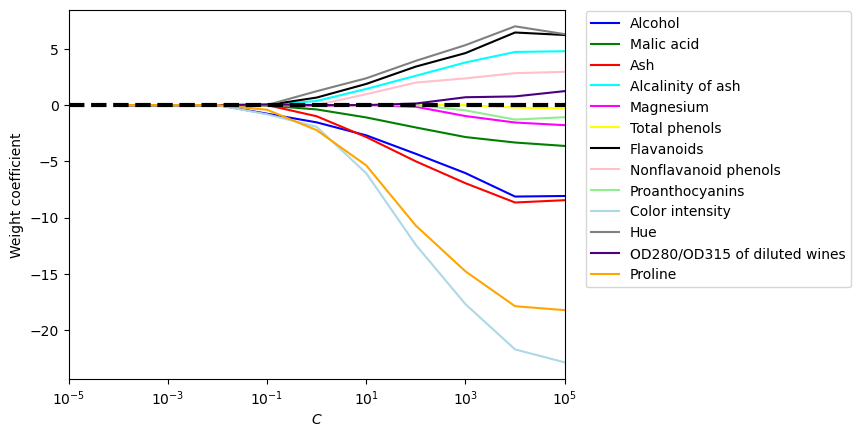

In [103]:
fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow',
          'black', 'pink', 'lightgreen', 'lightblue', 'gray',
          'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(solver='liblinear',
                            penalty='l1', C=10.**c,
                            random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('Weight coefficient')
plt.xlabel('$C$')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.31, 1.015),
          ncol=1, fancybox=True)
plt.show()

결과 그래프를 보면 L1 규제에 대해 덜 잘 이해할 수 있습니다. 여기서 볼 수 있듯이 강한 규제 파라미터($C<0.1$)로 모델을 제약하면 모든 가중치가 0이 됩니다. 다시 말하지만 $C$는 규제 파라미터 $\lambda$의 역수입니다.

## 5.6 차원 축소
모델 복잡도를 줄이고 오버피팅을 피하는 다른 방법은 특성 선택을 통한 **차원 축소**(dimensionality reduction)입니다. 이 방법은 규제가 없는 모델에서 특히 유용하며, 두 개의 주요 카테고리인 **특성 선택**(feature selection)과 **특성 추출**(feature extraction)이 있습니다. 특성 선택은 원본 특성에서 일부를 선택합니다. 특성 추출은 일련의 특성에서 얻은 정보로 새로운 특성을 만듭니다.
### 5.6.1 순차 특성 선택 알고리즘
순차 특성 선택(sequential feature selection) 알고리즘은 초기 $d$차원의 특성 공간을 $k < d$인 $k$차원의 특성 부분공간으로 축소합니다. 특성 선택 알고리즘은 주어진 문제에 가장 관련이 높은 특성 부분집합을 자동으로 선택하는 것이 목적입니다. 관계없는 특성이나 잡음을 제거하여 계산 효율성을 높이고 모델의 일반화 오차를 줄입니다. 규제를 제공하지 않는 알고리즘을 사용할 때 유용합니다.  
전통적인 순차 특성 선택 알고리즘은 **순차 후진 선택**(Sequential Backward Selection, SBS)입니다. 계산 효율성을 향상하기 위해 모델 성능을 가능한 한 적게 희생하면서 초기 특성의 부분공간으로 차원을 축소합니다. 오버피팅의 문제를 안고 있는 모델이라면 SBS가 예측 성능을 높일 수도 있습니다.  
순차 특성 선택 알고리즘은 사이킷런 0.24 버전 이후로 `SequentialFeatureSelector` 클래스로 구현되어있습니다. 규제항을 추가할 수 없는 모델인 결정 트리 모델을 사용하여 이 클래스의 작동을 확인하겠습니다.

In [104]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier

In [105]:
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=3,
                                    random_state=1)

`SequentialFeatureSelector`의 사용법을 간단하게 소개하고 넘어가겠습니다. 이 클래스는 사용하고자 하는 추정기의 종류를 입력으로 받습니다. 여기서는 결정 트리 모델인 `tree_model`이 해당하겠죠. 그 후, 우리가 선택하고자 하는 목표 특성의 개수를 `n_features_to_select` 인수에 넣어줍니다. 여기서는 데이터셋의 특성을 가장 잘 표현할 수 있는 단 하나의 특성을 찾는다고 가정하고 값을 1로 설정했습니다. `direction`은 순차 전진 선택을 할 지, 순차 후진 선택을 할 지를 정하는 인수입니다. 여기서는 SBS 알고리즘을 사용한다는 가정 하에 `'backward'`로 넣어줬습니다. `n_jobs`에서 병렬 처리에 사용할 CPU 코어의 개수를 선택할 수도 있으니 사용 중인 컴퓨터 사양에 맞춰서 넣어주면 좋습니다.
> <span style='background-color:blue'>여담</span> 교차검증<br/>
`SequentialFeatureSelector`에는 6단원에서 다룰 교차검증 관련 키워드가 존재합니다. 기본값은 `cv=5`로, 5회에 걸쳐 검증 횟수를 나눕니다. 회귀 모델의 경우 `KFold`, 분류 모델의 경우 `StratifiedKFold`를 사용하여 폴드를 나눕니다. 자세한 얘기는 6단원에서 하도록 하고, 여기서는 기본값을 그대로 사용하겠습니다.

In [106]:
sfs = SequentialFeatureSelector(estimator=tree_model, n_features_to_select=1,
                                direction='backward', n_jobs=4)

In [107]:
sfs.fit(X_train, y_train)

SequentialFeatureSelector(direction='backward',
                          estimator=DecisionTreeClassifier(max_depth=3,
                                                           random_state=1),
                          n_features_to_select=1, n_jobs=4)

SFS, SBS 구현은 `fit()` 메서드 안에서 입력받은 데이터셋을 훈련 데이터셋과 테스트 데이터셋으로 나눕니다. 하지만 그럼에도 불구하고 우리는 *실제* 훈련 데이터셋에 해당하는 `X_train_std`만 입력했습니다. 왜 그럴까요? `sfs`의 `fit()` 메서드는 훈련과 테스트, 정확히는 검증을 위해 새로운 부분집합(subset)을 만듭니다. 이렇게 생성된 부분집합인 테스트 데이터셋은 **검증 데이터셋**(validation dataset)이라고도 부릅니다. 이 방식을 사용하려면 훈련 데이터에서 원래 테스트 데이터셋을 미리 떼어놓아야 합니다. 따라서 미리 훈련/테스트 데이터셋을 분리해놓고 `sfs`에 훈련 데이터셋만 입력한 우리의 선택은 적절한 판단인 것입니다.  
SFS, SBS 알고리즘은 훈련의 각 단계에서 가장 좋은 특성 조합의 점수를 모아놨습니다. 이제 검증 데이터셋에서 계산한 분류기의 정확도를 그려보겠습니다.

In [108]:
scores = []
for n_features in range(1, 13):
    sfs = SequentialFeatureSelector(estimator=tree_model, n_features_to_select=n_features,
                                    direction='backward', n_jobs=4)
    sfs.fit(X_train, y_train)
    f_mask = sfs.support_ 
    tree_model.fit(X_train[:, f_mask], y_train)
    scores.append(tree_model.score(X_train[:, f_mask], y_train))

In [109]:
# 13개 특성을 모두 넣고 학습시킨 결과
tree_model.fit(X_train, y_train)
scores.append(tree_model.score(X_train, y_train))

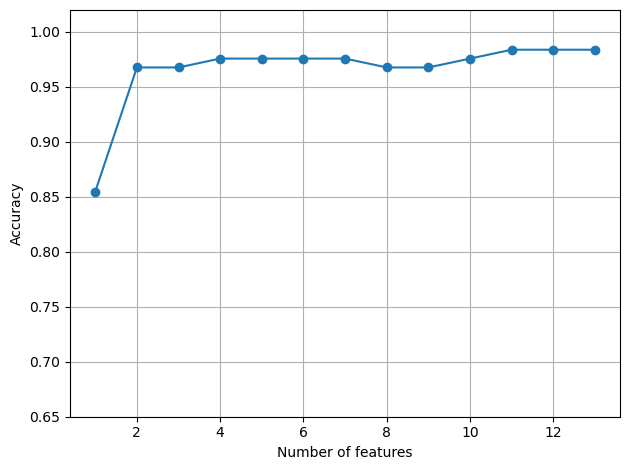

In [110]:
plt.plot(range(1, len(scores)+1), scores, marker='o')
plt.ylim([0.65, 1.02])
plt.ylabel("Accuracy")
plt.xlabel("Number of features")
plt.grid()
plt.tight_layout()
plt.show()

위 그림에서 볼 수 있듯이 특성 개수가 줄었을 때도 *검증 데이터셋에서* 분류기의 정확도는 웬만큼 높은 수준으로 유지됩니다. $4\le k\le 13$에서 분류기가 100%의 정확도를 달성한 것을 볼 수 있습니다. 이는 소위 **차원의 저주**(curse of dimensionality)가 감소하기 때문입니다. 차원의 저주란 고정된 크기의 훈련 데이터셋이 차원이 늘어남에 따라 특성 공간이 점점 희소해지는 현상입니다.  
정확도가 0.95 이상인 $k$ 중 가장 작은 개수의 조합($k=2$)에서 높은 검증 데이터셋 성능을 내는 특성이 어떤 것인지 확인해보겠습니다.

In [111]:
sfs = SequentialFeatureSelector(estimator=tree_model, n_features_to_select=2,
                                direction='backward', n_jobs=4)
sfs.fit(X_train, y_train)

SequentialFeatureSelector(direction='backward',
                          estimator=DecisionTreeClassifier(max_depth=3,
                                                           random_state=1),
                          n_features_to_select=2, n_jobs=4)

In [112]:
k2 = sfs.support_
k2

array([False, False, False, False, False, False,  True, False, False,
        True, False, False, False])

In [113]:
print(df_wine.columns[1:][k2])

Index(['Flavanoids', 'Color intensity'], dtype='object')


이 코드는 `sfs.support_` 속성으로부터 훈련 결과로 얻어진 2개의 특성에 해당하는지를 판단하는 불리언 배열을 반환합니다. 이 불리언 배열에 해당하는 와인 데이터셋의 특성 열의 이름을 반환받은 것입니다.  
이제 원래 테스트 데이터셋에서 결정 트리 분류기의 성능을 평가하겠습니다.

In [114]:
tree_model.fit(X_train, y_train)
print("훈련 정확도:", tree_model.score(X_train, y_train))
print("테스트 정확도:", tree_model.score(X_test, y_test))

훈련 정확도: 0.9838709677419355
테스트 정확도: 0.8518518518518519


In [115]:
tree_model.fit(X_train[:, k2], y_train)
print("훈련 정확도:", tree_model.score(X_train[:, k2], y_train))
print("테스트 정확도:", tree_model.score(X_test[:, k2], y_test))

훈련 정확도: 0.967741935483871
테스트 정확도: 0.9259259259259259


와인 데이터셋에 있는 원본 특성 중 고작 6분의 1도 안 되는 적은 특성을 사용했지만 오히려 테스트 정확도는 기존의 모델보다 약 6% 증가했습니다. 이 두 개의 특성에 담긴 판별 정보가 원래 데이터셋보다 결코 적지 않다는 것입니다. 와인 데이터셋은 작은 데이터셋이라는 점을 유념하세요. 무작위성에 매우 민감하다는 뜻입니다. 즉, 데이터셋을 훈련 데이터셋과 테스트 데이터셋으로 나눈 것과 훈련 데이터셋을 다시 훈련 서브셋과 검증 서브셋으로 나눈 방식에 영향을 받습니다.  
모델의 종류에 따라 순차 선택 알고리즘을 사용해도 성능이 증가하지는 않을 수도 있습니다. 그러나 데이터 수집 비용이 높은 실전 애플리케이션에서는 이 방법이 유용할 수 있습니다. 또한 특성 개수를 크게 줄였기 때문에 더 간단한 모델을 얻었고 해석하기도 쉽습니다.

### 5.6.2 랜덤 포레스트의 특성 중요도 사용
데이터셋에서 유용한 특성을 선택하는 또다른 방법은 랜덤 포레스트를 사용하는 방법입니다. ~~일종의 꼼수에 가깝긴 하지만~~ 랜덤 포레스트를 사용하면 앙상블에 참여한 모든 결정 트리에서 계산한 평균 불순도 감소로 특성 중요도를 측정할 수 있습니다. 편리하게도 사이킷런의 랜덤 포레스트 구현은 특성 중요도 값을 이미 수집하고 있습니다. `RandomForestClassifier` 모델을 훈련한 후 `feature_importances_` 속성에서 확인할 수 있습니다.

In [116]:
from sklearn.ensemble import RandomForestClassifier

In [117]:
feat_labels = df_wine.columns[1:]

In [118]:
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=1)

In [119]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

In [121]:
for f in range(X_train.shape[1]):
    print(f"{f + 1:2d}) {feat_labels[indices[f]]} {importances[indices[f]]:.6f}")

 1) Proline 0.185453
 2) Flavanoids 0.174751
 3) Color intensity 0.143920
 4) OD280/OD315 of diluted wines 0.136162
 5) Alcohol 0.118529
 6) Hue 0.058739
 7) Total phenols 0.050872
 8) Magnesium 0.031357
 9) Malic acid 0.025648
10) Proanthocyanins 0.025570
11) Alcalinity of ash 0.022366
12) Nonflavanoid phenols 0.013354
13) Ash 0.013279


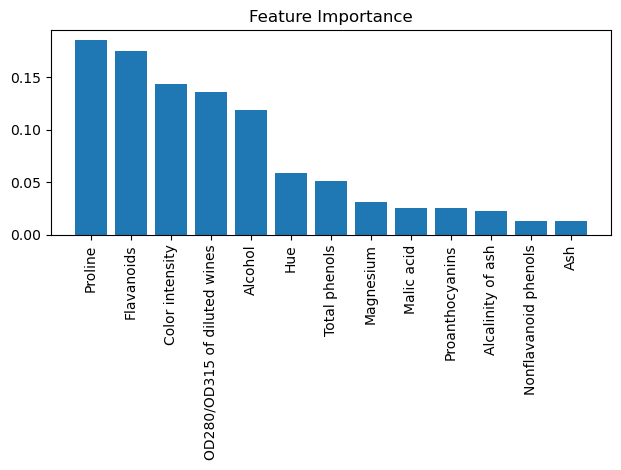

In [122]:
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices],
        align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices],
           rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

500개의 결정 트리에서 평균적인 불순도 감소를 기반으로 이 데이터셋에서 가장 판별력이 좋은 특성은 Proline, Flavanoids, Color intensity, OD280/OD345 of diluted wines, Alcohol입니다. 재밌게도 이 그래프에서 높은 순위에 위치한 특성 중 2개인 Flavanoids와 Color intensity는 앞선 절에서 구현한 `sfs` 객체에서 선택한 그 두 개체이기도 합니다.  
모델 해석을 중요하게 고려한다면 랜덤 포레스트 기법에서 언급할 만한 중요한 참고사항이 있습니다. 랜덤 포레스트에서 두 개 이상의 특성이매우 상관관계가 높다면 하나의 특성은 매우 높은 순위를 갖지만 다른 특성 정보는 완전히 잡아내지 못할 수 있습니다. 특성 중요도 값을 해석하는 것보다 모델의 예측 성능에만 관심이 있다면 이 문제는 신경 쓸 필요가 없습니다.  
특성 중요도 설명을 마무리하기 위해 사이킷런의 `SelectFromModel`을 살펴보겠습니다. 이 클래스는 훈련이 끝난 모델에 대해 사용자가 지정한 임계값을 기반으로 특성을 선택합니다. `Pipeline`의 중간 단계에서 `RandomForestClassifier`를 특성 선택기로 사용할 때 유용합니다. 7단원에서 살펴볼 `Pipeline` 클래스는 여러 전처리 단계를 하나의 추정기 인터페이스로 연결해 줍니다. 예를 들어 다음 코드에서는 임계값을 0.1로 하여 가장 중요한 다섯 개의 특성으로 데이터셋을 줄였습니다.

In [123]:
from sklearn.feature_selection import SelectFromModel

In [124]:
sfm = SelectFromModel(forest, threshold=0.1, prefit=True)

In [125]:
X_selected = sfm.transform(X_train)

In [126]:
print("이 임계조건을 만족하는 샘플의 개수:", X_selected.shape[1])

이 임계조건을 만족하는 샘플의 개수: 5


In [127]:
for f in range(X_selected.shape[1]):
    print(f"{f + 1:2d}) {feat_labels[indices[f]]} {importances[indices[f]]:.6f}")

 1) Proline 0.185453
 2) Flavanoids 0.174751
 3) Color intensity 0.143920
 4) OD280/OD315 of diluted wines 0.136162
 5) Alcohol 0.118529


### 5.6.3 특성 추출
차원 축소의 또다른 방식은 **특성 추출**(feature extraction)입니다. 이들은 원본 데이터셋을 좀 더 낮은 차원의 새로운 특성 부분 공간으로 *변환*합니다. 특성 선택 알고리즘을 사용할 때는 원본의 특성이 유지되지만, 특성 추출은 새로운 특성 공간으로 데이터를 변환하거나 투영합니다. 차원 축소 관점에서 보면 특성 추출은 대부분의 관련 있는 정보를 유지하면서 데이터를 압축하는 방법으로 이해할 수 있습니다. 특성 추출이 저장 공간을 절약하거나 학습 알고리즘의 계산 효율성을 향상할 뿐만 아니라 차원의 저주 문제를 감소시켜 예측 성능을 향상하기도 합니다. 특히 규제가 없는 모델로 작업할 때 그렇습니다.
#### 5.6.3.1 주성분 분석을 통한 비지도 차원 축소
먼저 *비지도* 선형 변환 기법인 주성분 분석(Principal Component Analysis, PCA)을 다룹니다. 이 기법은 주로 탐색적 데이터 분석(Exploratory Data Analysis, EDA)과 주식 시장의 잡음 제거, 생물정보학 분야에서 게놈(genome) 데이터나 유전자 발현(gene expression) 문제 등에 사용합니다.
PCA는 특성들 간의 상관관계를 기반으로 데이터에 있는 특성을 잡아낼 수 있습니다. 최대한 간단하게 말하자면 고차원 데이터에서 분산이 가장 큰 방향을 찾고 좀 더 작거나 같은 수의 차원을 갖는 새로운 부분공간으로 데이터셋을 투영합니다. 새로운 부분공간의 직교좌표(주성분)는 주어진 조건 하에서 분산이 최대인 방향으로 해석할 수 있습니다. 새로운 특성 축은 아래 그림과 같이 서로 직각을 이룹니다.  
![그림 5-6](https://github.com/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch05/images/05_01.png?raw=true)  
위 그림에서 $x_1$과 $x_2$는 원본 특성 축이고 PC1과 PC2는 새로운 부분공간의 주성분입니다.  
PCA 클래스의 정확한 구동 방식은 ch05Bonus_preprocessing.md 파일을 참고해주세요. 여기서는 이 구현 방식을 하나로 합친 사이킷런의 `PCA` 클래스를 사용해 와인 데이터셋을 축소하는 예제를 풀어보겠습니다.

In [128]:
from sklearn.decomposition import PCA
from script import plot_decision_regions # 결정 경계를 그리는 함수를 별도의 파이썬 모듈로 분리했습니다.

In [129]:
# PCA 변환기와 로지스틱 회귀 추정기를 초기화.
pca = PCA(n_components=2) # 주성분 2개의 평면으로 축소.
lr = LogisticRegression(random_state=1)

In [130]:
# 차원 축소
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

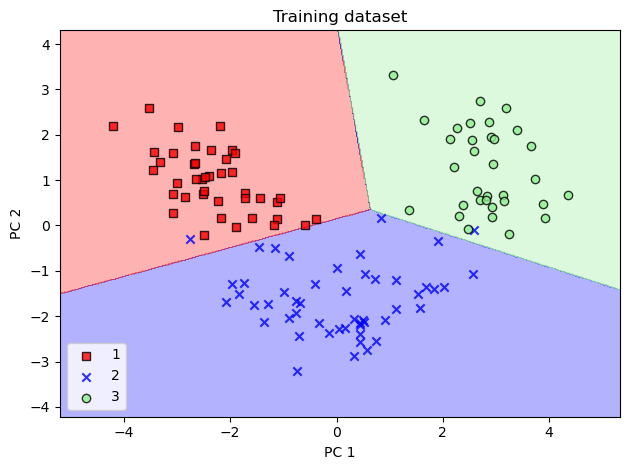

In [132]:
# 축소된 데이터셋으로 로지스틱 회귀 모델 훈련
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr) # 훈련 데이터셋 결정 경계
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Training dataset")
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

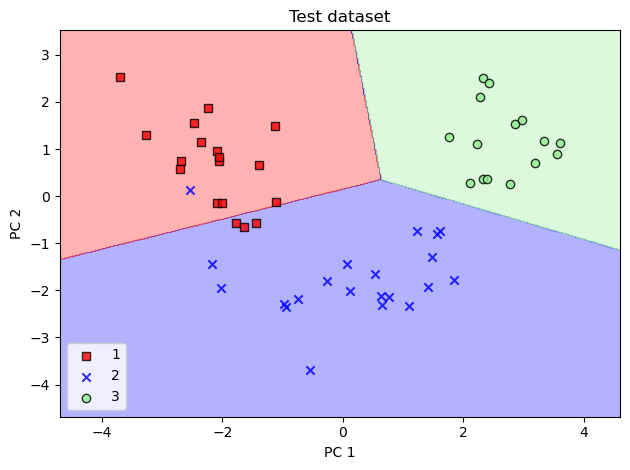

In [133]:
plot_decision_regions(X_test_pca, y_test, classifier=lr) # 테스트 데이터셋 결정 경계
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Test dataset")
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

이 코드를 실행하여 결정 경계를 그리고 나면 로지스틱 회귀가 2차원 특성 부분공간에서 매우 잘 작동한다는 것을 알 수 있습니다. 몇몇 샘플만 분류하지 못했습니다.  

### 5.6.3.2 선형 판별 분석을 통한 지도 방식의 데이터 압축
**선형 판별 분석**(Linear Discriminant Analysis, LDA)의 개념은 PCA와 매우 비슷합니다. PCA가 데이터셋에 있는 분산이 최대인 직교 성분 축을 찾는 것이 목표라면, LDA는 클래스를 최적으로 구분할 수 있는 특성 부분공간을 찾는 것입니다. 차이점이 있다면 PCA는 비지도학습 알고리즘이지만 LDA는 지도학습 알고리즘이라는 것이죠. 따라서 LDA가 PCA보다 분류 작업에서 더 뛰어난 특성 추출 기법이라고 볼 수 있습니다. 실제로도 PCA를 통한 전처리가 특정 미지 인식 작업에 더 뛰어난 분류 결과를 내는 경향이 있다는 연구 결과가 있습니다([출처: Martinez, Aleix M., and Avinash C. Kak. "Pca versus lda." IEEE transactions on pattern analysis and machine intelligence 23.2 (2001): 228-233.](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=cadb9a014a4c5bbec57aaf30391f472fa4b69b4d))  
LDA는 데이터가 정규분포라고 가정합니다. 이 때문에 사용하려는 모델의 종류와 무관하게 데이터셋의 표준화 전처리가 필수로 여겨집니다. 또한 클래스가 동일한 공분산 행렬을 가지고 훈련 샘플은 서로 통계적으로 독립이라고 가정합니다. 하지만 하나 이상의 가정이 (조금) 위반되더라도 여전히 LDA는 차원 축소를 상당히 잘 수행합니다.
![그림 5-6](https://github.com/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch05/images/05_06.png?raw=true)  
위 그림은 이진 분류 문제를 위한 LDA 개념을 요약하여 나타냅니다. 클래스 1의 샘플은 동그라미이고 클래스 2의 샘플은 더하기 기호입니다.  
$x$축(LD 1)으로 투영하는 선형 판별 벡터는 두 개의 정규분포 클래스를 잘 구분합니다. $y$축(LD 2)으로 투영하는 선형 판별 벡터는 데이터셋에 있는 분산을 많이 잡아내지만 클래스 판별 정보가 없기 때문에 좋은 선형 판별 벡터가 되지 못합니다.  
그럼 사이킷런에 구현된 `LDA` 클래스를 살펴보죠.

In [134]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [135]:
lda = LDA(n_components=2)

In [136]:
X_train_lda = lda.fit_transform(X_train_std, y_train)

다음 LDA로 변환한 저차원 훈련 데이터셋에 로지스틱 회귀 분류기가 잘 동작하는지 확인해보겠습니다.

In [137]:
lr = LogisticRegression(random_state=1)

In [138]:
lr.fit(X_train_lda, y_train)

LogisticRegression(random_state=1)

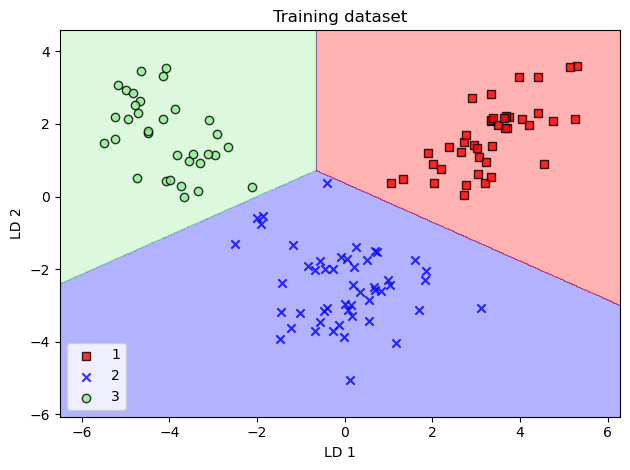

In [139]:
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel("LD 2")
plt.title("Training dataset")
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

그런대로 훈련 데이터셋은 정확하게 분류가 되었군요. 하지만 더 중요한 것은 테스트 데이터셋의 결과입니다.

In [140]:
X_test_lda = lda.transform(X_test_std)

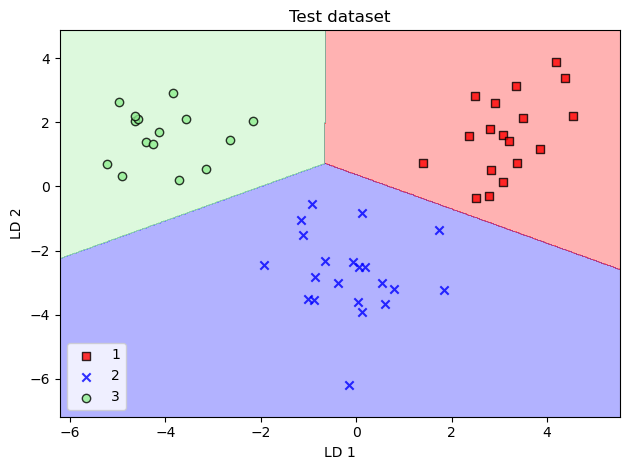

In [141]:
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel("LD 2")
plt.title("Test dataset")
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

다음 그래프에서 볼 수 있듯이 로지스틱 회귀 분류기는 원본 와인 데이터셋의 13개의 특성 대신 2차원의 특성 부분공간을 사용해서 테스트 데이터셋에 있는 모든 샘플을 완벽하게 분류했습니다.

---------------------------------------------------
지금까지 선형 특성 추출 기법을 소개했습니다. 그러나 실전 애플리케이션에서는 비선형 문제를 더 자주 맞닥뜨릴 것입니다. 이런 비선형 문제를 다뤄야 한다면 PCA와 LDA 같은 차원 축소를 위한 선형 변환 기법은 최선의 선택이 아닙니다. 이를 위해 비선형 매핑을 통한 부분공간 투영 기법을 도입하기도 합니다.